<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [1]:
!pip install tensorflow_hub

In [2]:
import numpy as np
import cv2
import PIL as PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [6]:
!pip install --upgrade tensorflow tensorflow_hub

In [10]:
IMAGE_SHAPE = (224, 224)

classifier =hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", 
                   input_shape=IMAGE_SHAPE+(3,), trainable=False)

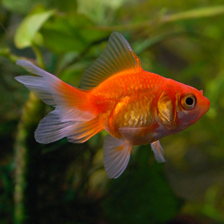

In [3]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [4]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [5]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [6]:
temp=gold_fish[np.newaxis, ...]

In [7]:
temp.shape

(1, 224, 224, 3)

In [8]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 [==============================] - 1s 1s/step


(1, 1001)

In [9]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [10]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [11]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

In [13]:
data_dir

'.\\datasets\\flower_photos'

In [14]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [15]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('datasets/flower_photos/daisy/100080576_f52e8ee070_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10140303196_b88d3d6cec.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172379554_b296050f82_n.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172567486_2748826a8b.jpg'),
 WindowsPath('datasets/flower_photos/daisy/10172636503_21bededa75_n.jpg')]

In [16]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [17]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

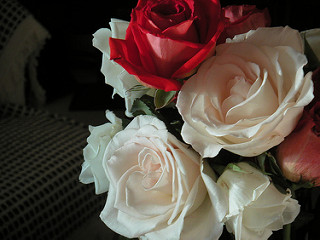

In [18]:
PIL.Image.open(str(roses[1]))

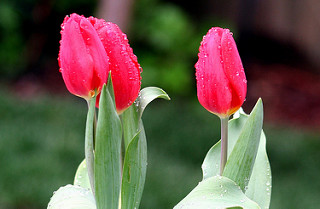

In [19]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [20]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [21]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [22]:
flowers_images_dict['roses'][:5]

[WindowsPath('datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

In [23]:
str(flowers_images_dict['roses'][0])

'datasets\\flower_photos\\roses\\10090824183_d02c613f10_m.jpg'

In [24]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [25]:
img.shape

(240, 179, 3)

In [26]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [27]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [28]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [30]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [31]:
X[0].shape

(224, 224, 3)

In [32]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [33]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

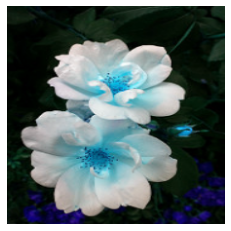

In [34]:
plt.axis('off')
plt.imshow(X[0])

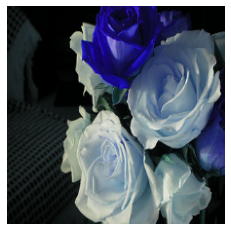

In [35]:
plt.axis('off')
plt.imshow(X[1])

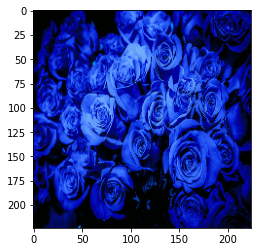

In [37]:

plt.imshow(X[2])

In [38]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 1s 1s/step


array([795, 880, 795], dtype=int64)

In [39]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [40]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [41]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 5)                 6405      
                                                                 
Total params: 2264389 (8.64 MB)
Trainable params: 6405 (25.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [42]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 51s 527ms/step - loss: 0.8531 - acc: 0.6853
Epoch 2/5
86/86 [==============================] - 44s 511ms/step - loss: 0.4248 - acc: 0.8554
Epoch 3/5
86/86 [==============================] - 46s 536ms/step - loss: 0.3279 - acc: 0.8888
Epoch 4/5
86/86 [==============================] - 46s 539ms/step - loss: 0.2708 - acc: 0.9099
Epoch 5/5
86/86 [==============================] - 60s 697ms/step - loss: 0.2393 - acc: 0.9233


In [43]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 29s 937ms/step - loss: 0.3858 - acc: 0.8660


[0.38583624362945557, 0.8660130500793457]

In [44]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

In [49]:
test_image_path = 'daisy.jpg'
test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

FileNotFoundError: [Errno 2] No such file or directory: 'daisy.jpg'